In [ ]:
!pip install backtrader

In [1]:
import sys
sys.path.append("/ibkr")

import os
import datetime
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout


import passwords
from databaseClass import DB
from utils import generate_df_from_sql_file, generate_list_from_sql_file
from utils import DataProcessor, ModelBuilder, Predictor
pd.set_option('display.max_rows', None)

2023-07-07 21:32:37.197957: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-07 21:32:37.218742: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
userName = passwords.userName
userPass = passwords.userPass
dataBaseName = passwords.dataBaseName
host = passwords.host

db = DB(userName=userName, userPass=userPass, dataBaseName=dataBaseName, host='ibkr_db', docker=True)

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [3]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Restrict TensorFlow to only use the first GPU
    tf.config.set_visible_devices(gpus[0], 'GPU')

    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


2023-07-07 21:32:43.184613: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 21:32:43.187221: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-07-07 21:32:43.187301: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
!nvidia-smi

Fri Jul  7 21:32:46 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.60.11    Driver Version: 525.60.11    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   56C    P2   116W / 350W |  11689MiB / 12288MiB |      4%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)
df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


In [8]:
class Backtester:
    def __init__(self, raw_data, initial_balance, preprocessor, model_builder, predictor, time_steps, look_ahead, num_runs):
        self.raw_data = raw_data
        self.initial_balance = initial_balance
        self.preprocessor = preprocessor
        self.model_builder = model_builder
        self.predictor = predictor
        self.time_steps = time_steps
        self.look_ahead = look_ahead
        self.num_runs = num_runs
        self.data = pd.DataFrame({
            'Actual': np.zeros(len(self.raw_data)),  # Initialize as zeros
            'Predicted': np.zeros(len(self.raw_data)),
            'Order': np.zeros(len(self.raw_data)),
            'Holdings': np.zeros(len(self.raw_data)),
            'Cash': np.full(len(self.raw_data), initial_balance),
            'Total': np.full(len(self.raw_data), initial_balance)
        }, index=self.raw_data.index).copy()
        self.model_builder.load_model("../models/model.h5")
        self.predictor.model = self.model_builder.model

    def run(self):
        position = 0
        # Preprocess the entire raw data
        self.preprocessor.df = self.raw_data.copy()
        self.preprocessor.process_df()
        self.preprocessor.scale_shift_data(look_ahead=0, for_training=False)
        for i in range(self.time_steps, len(self.data)):
            # Get the preprocessed data for the past 'time_steps' periods
            new_data = self.preprocessor.processed_df.iloc[i - self.time_steps : i]
            
            # Assume that your preprocessed data now has a 'Close' column
            actual_price_now = new_data['Close'].iloc[-1]  # Get the latest 'Close' price
            self.data.iat[i, self.data.columns.get_loc('Actual')] = actual_price_now  # Update 'Actual' price
            
            X = self.preprocessor.scaled_df
            X = self.preprocessor.create_dataset(X, y=None, time_steps=self.time_steps, look_ahead=0, for_training=False)
            predictions = self.predictor.predict(time_steps=self.time_steps, for_training=False, batch_size=1)
            rescaled_predictions = self.predictor.rescale_prediction(predictions)
            price = rescaled_predictions[-1][0]
            self.data.iat[i, self.data.columns.get_loc('Predicted')] = price

            actual_price_now = self.data.iat[i, self.data.columns.get_loc('Actual')]
            # Buy condition
            if price > actual_price_now and position != 1:
                self.data.iat[i, self.data.columns.get_loc('Order')] = 1
                self.data.iat[i, self.data.columns.get_loc('Cash')] -= actual_price_now
                position = 1
            # Sell condition
            elif price < actual_price_now and position != -1:
                self.data.iat[i, self.data.columns.get_loc('Order')] = -1
                self.data.iat[i, self.data.columns.get_loc('Cash')] += actual_price_now
                position = -1
            self.data.iat[i, self.data.columns.get_loc('Holdings')] = position * actual_price_now
            self.data.iat[i, self.data.columns.get_loc('Total')] = self.data.iat[i, self.data.columns.get_loc('Cash')] + self.data.iat[i, self.data.columns.get_loc('Holdings')]
            # Copy Cash and Holdings to the next row
            if i < len(self.data) - 1:
                self.data.iat[i + 1, self.data.columns.get_loc('Cash')] = self.data.iat[i, self.data.columns.get_loc('Cash')]
                self.data.iat[i + 1, self.data.columns.get_loc('Holdings')] = self.data.iat[i, self.data.columns.get_loc('Holdings')]
        self.data.iat[-1, self.data.columns.get_loc('Total')] = self.data.iat[-1, self.data.columns.get_loc('Cash')] + self.data.iat[-1, self.data.columns.get_loc('Holdings')]
        return self.data


    def calculate_metrics(self):
        total_profit = self.data['Total'].iloc[-1] - self.initial_balance
        num_positive_trades = len(self.data[self.data['Order'] > 0])
        num_negative_trades = len(self.data[self.data['Order'] < 0])
        total_trades = num_positive_trades + num_negative_trades
        win_ratio = num_positive_trades / total_trades if total_trades != 0 else 0
        avg_profit_per_trade = total_profit / total_trades if total_trades != 0 else 0
        return_on_investment = total_profit / self.initial_balance
        daily_returns = self.data['Total'].pct_change().dropna()
        sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())
        metrics = {
            'Total Profit': total_profit,
            'Number of Positive Trades': num_positive_trades,
            'Number of Negative Trades': num_negative_trades,
            'Win Ratio': win_ratio,
            'Average Profit per Trade': avg_profit_per_trade,
            'Return on Investment': return_on_investment,
            'Sharpe Ratio': sharpe_ratio,
        }
        return metrics

    def plot_portfolio_values(self):
        fig, ax1 = plt.subplots(figsize=(10, 5))
        color = 'tab:blue'
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Actual Prices', color=color)
        ax1.plot(self.data['Actual'], color=color)
        ax1.tick_params(axis='y', labelcolor=color)
        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
        color = 'tab:red'
        ax2.set_ylabel('Total Value', color=color)
        ax2.plot(self.data['Total'], color=color)
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.title('Actual Prices and Portfolio Value Over Time')
        plt.show()

In [9]:
input_sql_file='../sql_files/test.sql'
df = generate_df_from_sql_file(input_sql_file, db)
df['timestamp'] = df['timestamp'].dt.tz_localize('UTC') #adding this to update to utc

# Define your parameters
n_features = 5
time_steps = 60  # Define your time_steps
look_ahead = 5  # Define your look_ahead


# Initialize your classes
preprocessor = DataProcessor(df)  # Use your actual preprocessor class and its parameters
model_builder = ModelBuilder(n_features, time_steps)  # Use your actual model builder class and its parameters
predictor = Predictor(model=None, preprocessor=preprocessor)  # Use your actual predictor class and its parameters



backtester = Backtester(df, initial_balance=10000, preprocessor=preprocessor, model_builder=model_builder, predictor=predictor, time_steps=time_steps, look_ahead=look_ahead, num_runs=1)

backtest_results = backtester.run()


# Print out the backtest results
print(backtest_results)

# You can also calculate and print out the metrics
metrics = backtester.calculate_metrics()
for metric, value in metrics.items():
    print(f'{metric}: {value}')

# And plot the portfolio values over time
backtester.plot_portfolio_values()

/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)
2023-07-07 21:34:00.250907: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:437] Could not create cudnn handle: CUDNN_STATUS_NOT_INITIALIZED
2023-07-07 21:34:00.250945: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:441] Memory usage: 79429632 bytes free, 12627410944 bytes total.
2023-07-07 21:34:00.250972: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:451] Possibly insufficient driver version: 525.60.11
2023-07-07 21:34:00.250983: W tensorflow/core/framework/op_kernel.cc:1828] OP_REQUIRES failed at cudnn_rnn_ops.cc:1762 : UNKNOWN: Fail to find the dnn implementation.


UnknownError: Graph execution error:

Fail to find the dnn implementation.
	 [[{{node CudnnRNN}}]]
	 [[sequential_1/lstm_3/PartitionedCall]] [Op:__inference_predict_function_9106]

In [5]:
preprocessor = DataProcessor(df)

In [6]:
preprocessor.process_df()

In [10]:
preprocessor.processed_df.tail(100)

Open     High      Low    Close  Volume
timestamp                                                            
2023-06-30 00:22:23+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:24+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:25+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:26+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:27+00:00  4434.00  4434.25  4434.00  4434.25     1.0
2023-06-30 00:22:28+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:29+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:30+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:31+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:32+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:33+00:00  4434.00  4434.25  4434.00  4434.00     6.0
2023-06-30 00:22:34+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:35+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:36+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:37+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:38+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:39+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:40+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:41+00:00  4434.25  4434.50  4434.25  4434.25     8.0
2023-06-30 00:22:42+00:00  4434.25  4434.50  4434.25  4434.25     1.0
2023-06-30 00:22:43+00:00  4434.25  4434.50  4434.25  4434.25     0.0
2023-06-30 00:22:44+00:00  4434.00  4434.25  4434.00  4434.25     3.0
2023-06-30 00:22:45+00:00  4434.00  4434.25  4434.00  4434.25     1.0
2023-06-30 00:22:46+00:00  4434.00  4434.50  4434.00  4434.25     4.0
2023-06-30 00:22:47+00:00  4434.25  4434.50  4434.25  4434.25     0.0
2023-06-30 00:22:48+00:00  4434.25  4434.50  4434.25  4434.25     0.0
2023-06-30 00:22:49+00:00  4434.00  4434.25  4434.00  4434.00     4.0
2023-06-30 00:22:50+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:51+00:00  4434.00  4434.25  4434.00  4434.00     0.0
2023-06-30 00:22:52+00:00  4433.75  4434.25  4433.75  4434.00     2.0
2023-06-30 00:22:53+00:00  4433.75  4434.25  4433.75  4434.00     1.0
2023-06-30 00:22:54+00:00  4434.00  4434.25  4434.00  4434.25    20.0
2023-06-30 00:22:55+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:56+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:57+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:58+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:22:59+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:23:00+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:23:01+00:00  4434.00  4434.25  4434.00  4434.25     0.0
2023-06-30 00:23:02+00:00  4433.75  4434.25  4433.75  4434.00    18.0
2023-06-30 00:23:03+00:00  4434.00  4434.25  4434.00  4434.00    10.0
2023-06-30 00:23:04+00:00  4433.75  4434.25  4433.75  4434.00     0.0
2023-06-30 00:23:05+00:00  4433.75  4434.25  4433.75  4434.00     0.0
2023-06-30 00:23:06+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:07+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:08+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:09+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:10+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:11+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:12+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:13+00:00  4433.75  4434.00  4433.75  4434.00     1.0
2023-06-30 00:23:14+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:15+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:16+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:17+00:00  4433.75  4434.00  4433.75  4434.00     0.0
2023-06-30 00:23:18+00:00  4433.75  4434

In [11]:
preprocessor.processed_df.to_csv("output.csv")

In [42]:
def test_on_unseen_data(unseen_df, model_path, look_ahead, time_steps, initial_balance):
    model = load_model(model_path)
    data_processor = DataProcessor(unseen_df)
    data_processor.process_df()
    data_processor.scale_shift_data(look_ahead)
    X_unseen, y_unseen = data_processor.create_dataset(data_processor.scaled_df, data_processor.shifted_df['Close'], time_steps)
    predictor = Predictor(model, data_processor)
    predictions_unseen = predictor.predict(look_ahead, time_steps)
    rescaled_predictions_unseen = predictor.rescale_prediction(predictions_unseen)
    rescaled_predictions_unseen = rescaled_predictions_unseen.flatten()

    actual_prices_unseen = data_processor.processed_df['Close'].values[time_steps+look_ahead:]
    actual_prices_unseen = actual_prices_unseen.flatten()

    processed_data_unseen = data_processor.processed_df.iloc[time_steps+look_ahead:]
    processed_data_unseen = processed_data_unseen.assign(Actual = actual_prices_unseen)
    backtester = Backtester(processed_data_unseen, rescaled_predictions_unseen, initial_balance)
    results = backtester.run()
    backtester.plot_portfolio_values()
    metrics = backtester.calculate_metrics()
    return results, metrics


/ibkr/databaseClass.py:111: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, con=conn)


695/695 [==============================] - 3s 4ms/step


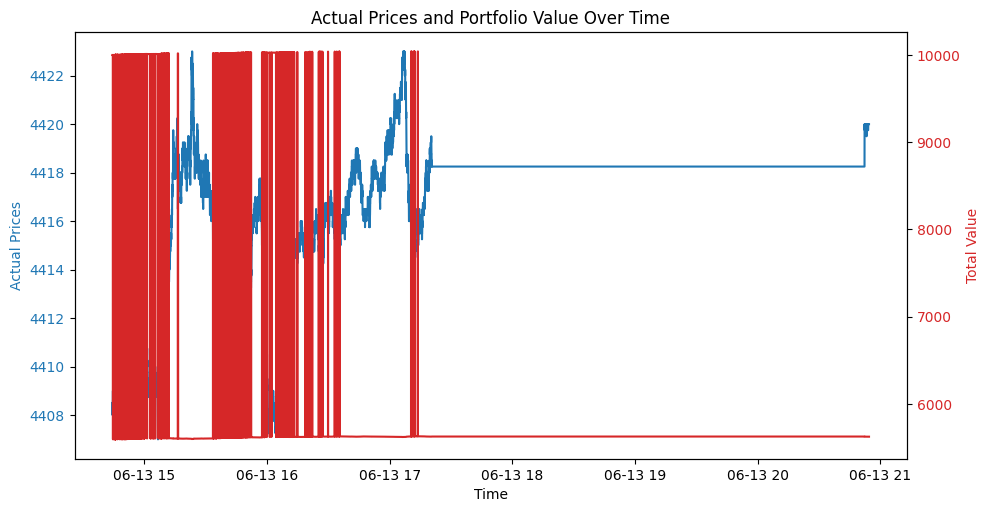

In [43]:
input_sql_file='../sql_files/jun13.sql'
unseen_df = generate_df_from_sql_file(input_sql_file, db)

model_path = "../models/model.h5"  # replace with the actual path to your saved model
look_ahead = 5  # replace with the value you used in training
time_steps = 60  # replace with the value you used in training
initial_balance = 10000
results, metrics = test_on_unseen_data(unseen_df, model_path, look_ahead, time_steps, initial_balance)